In [1]:

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum, count as _count, max as _max, date_add, current_date

In [2]:
# sc = SparkContext(master = 'local')

Step 1: Connect to the AdventureWorks2022 Database

In [6]:
jdbc_driver_path = "D:/Box/Apps/Spark/spark-3.5.3-bin-hadoop3/jars/mssql-jdbc-10.2.2.jre17.jar"
jdbc_url = "jdbc:sqlserver://TM420UA\\SQLEXPRESS:1433;databaseName=AdventureWorks2022;integratedSecurity=true;trustServerCertificate=true"
# Initialize Spark session
spark = SparkSession.builder.appName("ChurnAnalysis").config("spark.driver.extraClassPath", jdbc_driver_path).getOrCreate()
# spark = SparkSession.builder.appName("PySpark SQL Server AdventureWorksAnalysis").master('local').config("spark.jars", jdbc_driver_path).getOrCreate()

def read_sqlserver_query(query):
    return spark.read.format("jdbc") \
        .option("url", jdbc_url) \
        .option("query", query) \
        .option("driver", "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
        .load()

2. Loading Data from SQL Server
Need to load several tables related to sales, products, and customers from the AdventureWorks2022 database to perform this analysis. Below are some key tables for the analysis:

Sales.SalesOrderHeader: Contains sales order information like customer, order date, and total due.
Sales.Customer: Contains customer information (useful for identifying customer IDs).

In [7]:
# Load data from AdventureWorks2022 database
# Load data from AdventureWorks2022 database using SQL queries
customers_query = "SELECT * FROM Sales.Customer"
sales_order_header_query = "SELECT * FROM Sales.SalesOrderHeader"

customers_df = read_sqlserver_query(customers_query)
sales_order_header_df = read_sqlserver_query(sales_order_header_query)

sales_order_header_df.show

<bound method DataFrame.show of DataFrame[SalesOrderID: int, RevisionNumber: int, OrderDate: timestamp, DueDate: timestamp, ShipDate: timestamp, Status: int, OnlineOrderFlag: boolean, SalesOrderNumber: string, PurchaseOrderNumber: string, AccountNumber: string, CustomerID: int, SalesPersonID: int, TerritoryID: int, BillToAddressID: int, ShipToAddressID: int, ShipMethodID: int, CreditCardID: int, CreditCardApprovalCode: string, CurrencyRateID: int, SubTotal: decimal(19,4), TaxAmt: decimal(19,4), Freight: decimal(19,4), TotalDue: decimal(19,4), Comment: string, rowguid: string, ModifiedDate: timestamp]>

Step 3: Perform the Analysis

In [8]:
# current_date = current_date()

# High-Value Customers: Customers with the highest total purchase value

high_value_customers_query = """
    SELECT TOP 100 PERCENT c.CustomerID, SUM(soh.TotalDue) AS TotalSpent
    FROM Sales.SalesOrderHeader soh
    JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
    GROUP BY c.CustomerID
    ORDER BY TotalSpent DESC
    
"""
# Execute the query using the function
high_value_customers_df = read_sqlserver_query(high_value_customers_query)
print("High-Value Customers:")
high_value_customers_df.show()

High-Value Customers:
+----------+----------+
|CustomerID|TotalSpent|
+----------+----------+
|     14324| 5659.1783|
|     22814|    5.5140|
|     11407|   59.6590|
|     28387|  645.2869|
|     19897|  659.6408|
|     15675| 7963.0500|
|     24165| 3366.7583|
|     27036|    8.0444|
|     18546|   32.5754|
|     11453| 9035.5630|
|     17195| 3680.3876|
|     17026|  288.8360|
|     22768|  663.5083|
|     28433|   36.0230|
|     27082|  865.2040|
|     15844| 3464.1198|
|     12758|   82.8529|
|     21463|   26.4869|
|     18377| 2646.4419|
|     25562| 1369.1926|
+----------+----------+
only showing top 20 rows



In [14]:
one_year_ago = " DATEADD(year, -1, '2013-03-15')"

churned_high_value_customers_query = """
    SELECT TOP 100 PERCENT c.CustomerID, SUM(soh.TotalDue) AS TotalSpent, MAX(soh.OrderDate) AS LastOrderDate
    FROM Sales.SalesOrderHeader soh
    JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
    GROUP BY c.CustomerID
    HAVING MAX(soh.OrderDate) < DATEADD(year, -1, '2013-03-15')
    ORDER BY TotalSpent DESC
"""

# Execute the query using the function
churned_high_value_customers_df = read_sqlserver_query(churned_high_value_customers_query )

print("Churned high valuecustomers:")
churned_high_value_customers_df.show()

Churned high valuecustomers:
+----------+----------+-------------------+
|CustomerID|TotalSpent|      LastOrderDate|
+----------+----------+-------------------+
|     29017| 3953.9884|2011-11-15 00:00:00|
|     27726| 3953.9884|2011-07-07 00:00:00|
|     28573| 3953.9884|2011-09-21 00:00:00|
|     29475| 3756.9890|2011-11-29 00:00:00|
|     29140| 3953.9884|2011-12-06 00:00:00|
|     28018| 3953.9884|2011-07-02 00:00:00|
|     27577| 3953.9884|2011-06-08 00:00:00|
|     28184| 3953.9884|2011-08-22 00:00:00|
|     28221| 3953.9884|2011-09-15 00:00:00|
|     29157| 3953.9884|2011-12-17 00:00:00|
|     28470| 3756.9890|2012-02-04 00:00:00|
|     28390| 3729.3640|2011-06-26 00:00:00|
|     28407| 3729.3640|2011-10-14 00:00:00|
|     28825| 3953.9884|2011-11-05 00:00:00|
|     28164| 3953.9884|2011-08-14 00:00:00|
|     28181| 3953.9884|2011-08-04 00:00:00|
|     28765| 3953.9884|2011-10-11 00:00:00|
|     29163| 3953.9884|2011-12-11 00:00:00|
|     28805| 3953.9884|2011-11-25 00:00:00|
|  

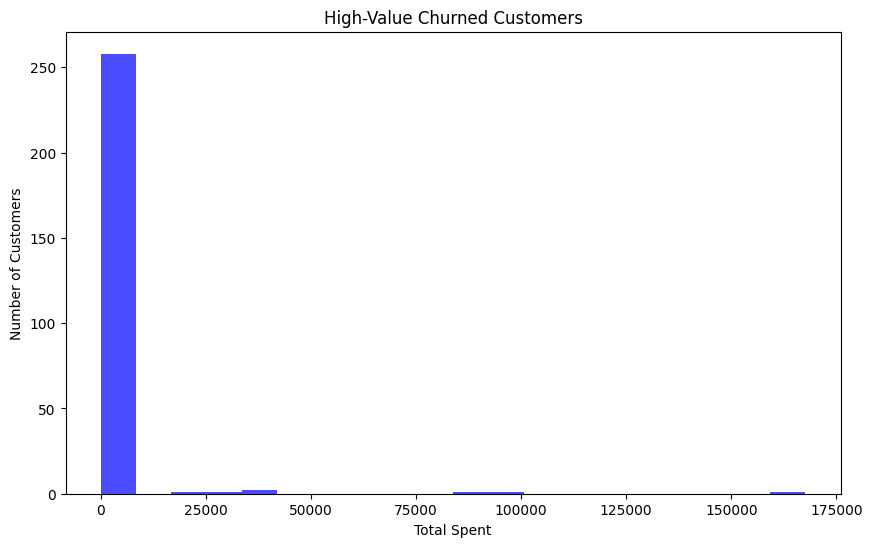

In [15]:
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame for visualization
high_value_churned_pd = churned_high_value_customers_df.toPandas()


# Plot high-value churned customers
plt.figure(figsize=(10, 6))
plt.hist(high_value_churned_pd["TotalSpent"], bins=20, color='blue', alpha=0.7)
plt.title("High-Value Churned Customers")
plt.xlabel("Total Spent")
plt.ylabel("Number of Customers")
plt.show()

In [ ]:
# Stop Spark session
spark.stop()